## Run inference on the Llama 2 endpoint you have created.

In [2]:
import json
import boto3

In [10]:
!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/1a/06/3817f9bb923437ead9a794f0ac0d03b8b5e0478ab112db4c413dd37c09da/transformers-4.33.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for huggingface-hub<1.0,>=0.15.1 from https://files.pythonhosted.org/packages/72/21/51cddb8850ed3f4dbc21e57c3dabc49e64d5577857ddda7b2eb0ffc2ec0e/huggingface_hub-0.17.2-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.17.2-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.2 MB/s eta 0:00:00:00:0100:01
  Obtaining dependency information for safetensors>=0.3.1 from https://files.pythonhosted.org/packages/21/12/d95158b4fdd0422faf019038be0be874d7bf3d9f9bd0b1b529f73853cec2/safetensors-0.3.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

tokenizer = AutoTokenizer.from_pretrained("upstage/Llama-2-70b-instruct")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Supported Parameters

***
This model supports the following inference payload parameters:

* **max_new_tokens:** Model generates text until the output length (excluding the input context length) reaches max_new_tokens. If specified, it must be a positive integer.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.

You may specify any subset of the parameters mentioned above while invoking an endpoint. 

**NOTE**: If `max_new_tokens` is not defined, the model may generate up to the maximum total tokens allowed, which is 4K for these models. This may result in endpoint query timeout errors, so it is recommended to set `max_new_tokens` when possible. For 7B, 13B, and 70B models, we recommend to set `max_new_tokens` no greater than 1500, 1000, and 500 respectively, while keeping the total number of tokens less than 4K.

**NOTE**: In order to support a 4k context length, this model has restricted query payloads to only utilize a batch size of 1. Payloads with larger batch sizes will receive an endpoint error prior to inference.

**NOTE**: This model only supports 'system', 'user' and 'assistant' roles, starting with 'system', then 'user' and alternating (u/a/u/a/u...).

***

In [27]:
# Zero Shot
"""dialogs = [
    [{"role": "user", "content": "what is the recipe of mayonnaise?"}],

   
]"""

#Few Shot

dialogs =  [
        {"role": "user", "content": "I am going to Paris, what should I see?"},
        {
            "role": "assistant",
            "content": """\
Paris, the capital of France, is known for its stunning architecture, art museums, historical landmarks, and romantic atmosphere. Here are some of the top attractions to see in Paris:

1. The Eiffel Tower: The iconic Eiffel Tower is one of the most recognizable landmarks in the world and offers breathtaking views of the city.
2. The Louvre Museum: The Louvre is one of the world's largest and most famous museums, housing an impressive collection of art and artifacts, including the Mona Lisa.
3. Notre-Dame Cathedral: This beautiful cathedral is one of the most famous landmarks in Paris and is known for its Gothic architecture and stunning stained glass windows.

These are just a few of the many attractions that Paris has to offer. With so much to see and do, it's no wonder that Paris is one of the most popular tourist destinations in the world.""",
        },
        {"role": "user", "content": "What is so great about #1?"},
    ],


### Query endpoint that you have created

---

To perform inference on these models, you need to pass custom_attributes='accept_eula=true' as part of header. This means you have read and accept the end-user-license-agreement (EULA) of the model. EULA can be found in model card description or from https://ai.meta.com/resources/models-and-libraries/llama-downloads/. By default, this notebook sets custom_attributes='accept_eula=false', so all inference requests will fail until you explicitly change this custom attribute. 

Note: Custom_attributes used to pass EULA are key/value pairs. The key and value are separated by '=' and pairs are separated by ';'. If the user passes the same key more than once, the last value is kept and passed to the script handler (i.e., in this case, used for conditional logic). For example, if 'accept_eula=false; accept_eula=true' is passed to the server, then 'accept_eula=true' is kept and passed to the script handler.

---

In [28]:
endpoint_name = "jumpstart-dft-meta-textgeneration-llama-2-13b-f"


def query_endpoint(payload):
    client = boto3.client("sagemaker-runtime")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/json",
        Body=json.dumps(payload),
        CustomAttributes="accept_eula=true",
    )
    response = response["Body"].read().decode("utf8")
    response = json.loads(response)
    return response

In [29]:
for dialog in dialogs:
    payload = {
        "inputs": [dialog], 
        "parameters": {"max_new_tokens": 100, "top_p": 0.9, "temperature": 0.6}
    }
    result = query_endpoint(payload)[0]
    for msg in dialog:
        print(f"{msg['role'].capitalize()}: {msg['content']}\n")
    print(f"> {result['generation']['role'].capitalize()}: {result['generation']['content']}")
    print("\n======\n")

User: I am going to Paris, what should I see?

Assistant: Paris, the capital of France, is known for its stunning architecture, art museums, historical landmarks, and romantic atmosphere. Here are some of the top attractions to see in Paris:

1. The Eiffel Tower: The iconic Eiffel Tower is one of the most recognizable landmarks in the world and offers breathtaking views of the city.
2. The Louvre Museum: The Louvre is one of the world's largest and most famous museums, housing an impressive collection of art and artifacts, including the Mona Lisa.
3. Notre-Dame Cathedral: This beautiful cathedral is one of the most famous landmarks in Paris and is known for its Gothic architecture and stunning stained glass windows.

These are just a few of the many attractions that Paris has to offer. With so much to see and do, it's no wonder that Paris is one of the most popular tourist destinations in the world.

User: What is so great about #1?

> Assistant:  There are many reasons why the Eiffel 

In [30]:
result['generation']['content']
result['generation']['role'].capitalize()

'Assistant'

Tokens per second: 50.98030946223049
Tokens per second: 50.62534048998845
Tokens per second: 50.773400477519345
Tokens per second: 50.80240097771871
Tokens per second: 50.48707096304589
Tokens per second: 50.768556222075865
Tokens per second: 50.79016367168788
Tokens per second: 50.62308809599737
Tokens per second: 51.028432237181256
Tokens per second: 50.81590564577875
Tokens per second: 50.76558625891933
Tokens per second: 51.057316631164035
Tokens per second: 50.76051463037415
Tokens per second: 51.349510070862294
Tokens per second: 50.622171620706034
Tokens per second: 50.983711678111874
Tokens per second: 50.69815990920716
Tokens per second: 50.77803471624731
Tokens per second: 50.85922570685298
Tokens per second: 50.83774674016542
Tokens per second: 50.86162614442491
Tokens per second: 50.70159667380068
Tokens per second: 50.66899021473436
Tokens per second: 50.76964067656619
Tokens per second: 50.607602324723366
Tokens per second: 50.74451733290696
Tokens per second: 51.07214604

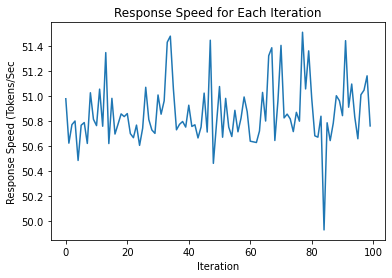

In [31]:
import time
import matplotlib.pyplot as plt



#max_length = 100
tokens_per_second_list = []

for _ in range(100):
    # Choose a payload from the payloads list    
    
    # Record the start time
    start_time = time.time()
    
    query_response =  query_endpoint(payload)[0]
    
    # Record the end time
    end_time = time.time()
    max_length=len(tokenizer(result['generation']['content'])['input_ids'])
    # Calculate the tokens per second
    elapsed_time = end_time - start_time
    tokens_per_sec = max_length / elapsed_time
    
    # Store the response time
    tokens_per_second_list.append(tokens_per_sec)
    
    print(f"Tokens per second: {tokens_per_sec}")
    #print(payload["inputs"])
    #print(f"> {query_response[0]['generation']}")
    #print("\n======\n")

# Plotting the response times
plt.plot(tokens_per_second_list)
plt.xlabel('Iteration')
plt.ylabel('Response Speed (Tokens/Sec')
plt.title('Response Speed for Each Iteration')
plt.show()


In [32]:
len(tokenizer(result['generation']['content'])['input_ids'])

102

In [33]:
inputs = tokenizer(str(list(payload.items())))
len(inputs['input_ids'])

312

# Now measure the TPS agains Concurrent Users

Average tokens per second for 1 users: 50.580468199682535
Average tokens per second for 2 users: 38.2536234022978
Average tokens per second for 3 users: 31.276607359201254
Average tokens per second for 4 users: 26.803772471710808
Average tokens per second for 5 users: 23.550543574374352
Average tokens per second for 6 users: 21.09847343688473
Average tokens per second for 7 users: 19.040415392472084
Average tokens per second for 8 users: 17.483988323353064
Average tokens per second for 9 users: 16.08057325742694
Average tokens per second for 10 users: 15.077368829825033


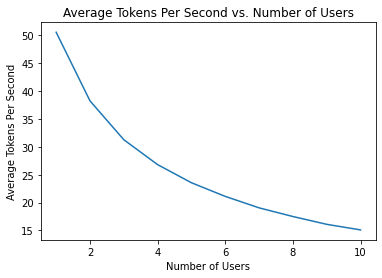

In [36]:
import time
import matplotlib.pyplot as plt
import concurrent.futures

# Assuming you have the tokenizer and query_endpoint functions defined as before

def measure_tokens_per_second(payload):
    start_time = time.time()
    query_response = query_endpoint(payload)[0]
    end_time = time.time()
    max_length = len(tokenizer(query_response['generation']['content'])['input_ids'])
    elapsed_time = end_time - start_time
    return max_length / elapsed_time

# List of payloads you want to send concurrently
payloads = [payload] * 11  # Replace with your actual data

# List to store average tokens per second for each number of users
avg_tokens_per_second_list = []

# Simulate for 1 to 100 users
for num_users in range(1, 11):
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_users) as executor:
        tokens_per_second_values = list(executor.map(measure_tokens_per_second, payloads[:num_users]))
        avg_tokens_per_second = sum(tokens_per_second_values) / num_users
        avg_tokens_per_second_list.append(avg_tokens_per_second)
        print(f"Average tokens per second for {num_users} users: {avg_tokens_per_second}")

# Plotting the average tokens per second vs. number of users
plt.plot(range(1, 11), avg_tokens_per_second_list)
plt.xlabel('Number of Users')
plt.ylabel('Average Tokens Per Second')
plt.title('Average Tokens Per Second vs. Number of Users')
plt.show()